#### This code generates large dataframe containing multiple timeseries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

from sklearn import tree

from sklearn.metrics import roc_curve, auc
#from sklearn.preprocessing import LabelBinarizer

from pandas.tseries.offsets import *

import time


#from graphviz import Source

#### parameters to set

In [3]:
n_series = 6
start_date = '2017-08-01 00:00:00'
end_date = '2017-08-07 23:59:59'

# regular behaviour
max_noise_amplitude = 0.05 # all the timeseries will have values between 0 and 1

# anomalies
p_anomaly = 10E-6
max_anomaly_duration = 4*3600 # 4 h

# tuning parameters
cut = 0.55
window = 24

#### generate normal data

In [4]:
dti=pd.DatetimeIndex(start=start_date,end=end_date, freq='s')
n_timesteps = len(dti)
df = pd.DataFrame()
for s in range(n_series):
    v = np.random.normal(random.random()/2, max_noise_amplitude/random.randint(1, 8), n_timesteps) 
    df['link '+str(s)] = pd.Series(v)
df['Flag']=0
df['auc_score']=0.5
df.index = dti
df.head()

,link 0,link 1,link 2,link 3,link 4,link 5,Flag,auc_score
2017-08-01 00:00:00,-0.010727,0.395373,0.458528,0.371284,0.492654,0.337991,0,0.5
2017-08-01 00:00:01,0.008714,0.402386,0.452096,0.368416,0.487514,0.329706,0,0.5
2017-08-01 00:00:02,0.012195,0.413203,0.451740,0.279915,0.457742,0.330869,0,0.5
2017-08-01 00:00:03,0.008187,0.412100,0.459605,0.285231,0.482462,0.338136,0,0.5
2017-08-01 00:00:04,0.000266,0.402319,0.456266,0.339051,0.487153,0.334796,0,0.5


#### generate anomalies

In [5]:
to_generate = int(n_timesteps * p_anomaly)
for a in range(to_generate):
    affects = random.sample(range(n_series), random.randint(1, n_series))
    duration = int(max_anomaly_duration * random.random())
    start = int(n_timesteps * random.random())
    end = min(start+duration, n_timesteps)
    print('affected:', affects, df.iloc[start].name, df.iloc[end].name)
    for s in affects:
        df.iloc[start:end,s] = df.iloc[start:end,s] + random.random() * 0.2
    df.iloc[start:end,n_series]=1
        

affected: [2] 2017-08-03 16:44:29 2017-08-03 20:19:51
affected: [5, 1] 2017-08-05 23:48:16 2017-08-06 03:20:15
affected: [3] 2017-08-05 07:30:10 2017-08-05 09:29:14
affected: [0, 5] 2017-08-02 07:08:06 2017-08-02 08:17:00
affected: [3, 2, 4] 2017-08-04 21:11:42 2017-08-04 23:04:29
affected: [5, 1, 4, 2, 3] 2017-08-06 17:02:41 2017-08-06 20:20:40


#### enforce range

In [6]:
df[df<0] = 0
df[df>1] = 1

#### plot timeseries

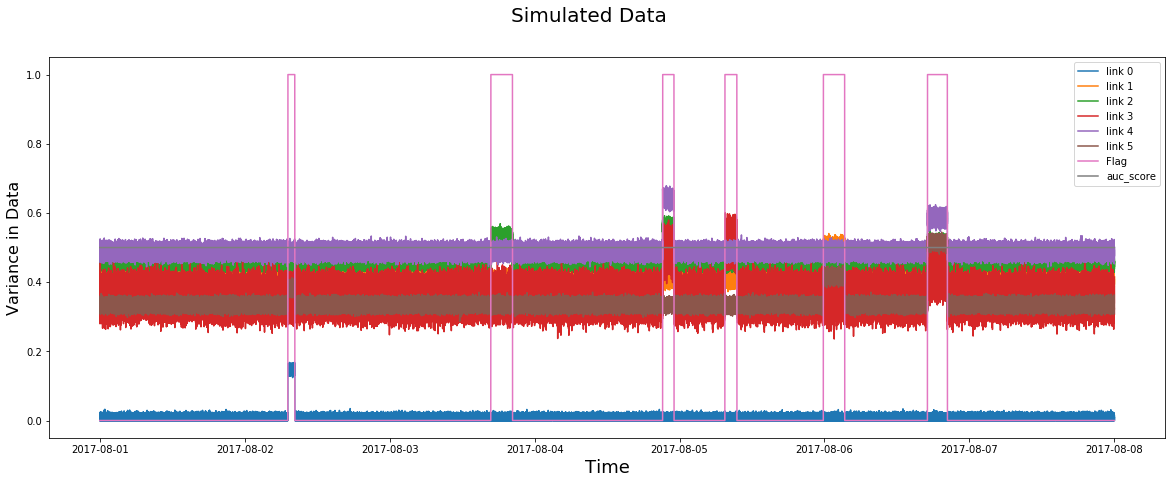

In [7]:
#df.plot(figsize=(20,7))
fig = plt.figure(figsize=(20,7))
plt.plot(df)
fig.suptitle('Simulated Data', fontsize=20)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Variance in Data', fontsize=16)
plt.legend(df)

In [8]:
#plt.figure(figsize=[16, 17])
#gs = gridspec.GridSpec(4, 1)

#ax2.plot(df)
#ax2.set_xlabel('time')
#ax2.set_ylabel('variance in data')
#ax2.legend()

#plt.show()

In [9]:
print(df['auc_score'])

2017-08-01 00:00:00    0.5
2017-08-01 00:00:01    0.5
2017-08-01 00:00:02    0.5
2017-08-01 00:00:03    0.5
2017-08-01 00:00:04    0.5
2017-08-01 00:00:05    0.5
2017-08-01 00:00:06    0.5
2017-08-01 00:00:07    0.5
2017-08-01 00:00:08    0.5
2017-08-01 00:00:09    0.5
2017-08-01 00:00:10    0.5
2017-08-01 00:00:11    0.5
2017-08-01 00:00:12    0.5
2017-08-01 00:00:13    0.5
2017-08-01 00:00:14    0.5
2017-08-01 00:00:15    0.5
2017-08-01 00:00:16    0.5
2017-08-01 00:00:17    0.5
2017-08-01 00:00:18    0.5
2017-08-01 00:00:19    0.5
2017-08-01 00:00:20    0.5
2017-08-01 00:00:21    0.5
2017-08-01 00:00:22    0.5
2017-08-01 00:00:23    0.5
2017-08-01 00:00:24    0.5
2017-08-01 00:00:25    0.5
2017-08-01 00:00:26    0.5
2017-08-01 00:00:27    0.5
2017-08-01 00:00:28    0.5
2017-08-01 00:00:29    0.5
                      ... 
2017-08-07 23:59:30    0.5
2017-08-07 23:59:31    0.5
2017-08-07 23:59:32    0.5
2017-08-07 23:59:33    0.5
2017-08-07 23:59:34    0.5
2017-08-07 23:59:35    0.5
2

In [10]:
print(df)

                       link 0    link 1    link 2    link 3    link 4  \
2017-08-01 00:00:00  0.000000  0.395373  0.458528  0.371284  0.492654   
2017-08-01 00:00:01  0.008714  0.402386  0.452096  0.368416  0.487514   
2017-08-01 00:00:02  0.012195  0.413203  0.451740  0.279915  0.457742   
2017-08-01 00:00:03  0.008187  0.412100  0.459605  0.285231  0.482462   
2017-08-01 00:00:04  0.000266  0.402319  0.456266  0.339051  0.487153   
2017-08-01 00:00:05  0.002968  0.408817  0.452565  0.315260  0.474379   
2017-08-01 00:00:06  0.008401  0.410944  0.452427  0.294080  0.482764   
2017-08-01 00:00:07  0.013943  0.396162  0.461759  0.350423  0.480078   
2017-08-01 00:00:08  0.000000  0.406584  0.460340  0.365206  0.501955   
2017-08-01 00:00:09  0.001417  0.414769  0.449504  0.306908  0.502825   
2017-08-01 00:00:10  0.002533  0.410125  0.468511  0.344270  0.491902   
2017-08-01 00:00:11  0.011306  0.404734  0.440553  0.351726  0.490667   
2017-08-01 00:00:12  0.009735  0.416090  0.453142  

#### functions

In [11]:
def check_for_anomaly(ref, sub):
    
    y_ref = pd.Series([0] * ref.shape[0])
    X_ref = ref
    #print("y_ref before: ", y_ref)
    #print("x_ref before: ", x_ref)
    del X_ref['Flag']
    del X_ref['auc_score']
    #print("x_ref after: ", X_ref)
    
    y_sub = pd.Series([1] * sub.shape[0])
    X_sub=sub
    #print("y_sub before: ", y_sub)
    #print("x_sub before: ", X_sub)
    del X_sub['Flag']
    del X_sub['auc_score']
    #print("X_sub after: ", X_sub)
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
#     dtc=DecisionTreeClassifier()
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6)) #dtc
#     clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME",n_estimators=200)
    
    #train an AdaBoost model to be able to tell the difference between the reference and subject data
    clf.fit(X_train, y_train) 

    #Predict using the combined test data
    y_predict = clf.predict(X_test)
    
    # scores = cross_val_score(clf, X, y)
    # print(scores)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
    auc_score = auc(fpr, tpr) #calculate the AUC score
    print ("auc_score = ", auc_score, "\tfeature importances:", clf.feature_importances_)
    
    if auc_score > cut: 
        plot_roc(fpr, tpr, auc_score)
        #filename='tree_'+sub.index.min().strftime("%Y-%m-%d_%H")
        #tree.export_graphviz(clf.estimators_[0] , out_file=filename +'_1.dot') 
        #tree.export_graphviz(clf.estimators_[1] , out_file=filename +'_2.dot') 
        
    return auc_score

In [12]:
def plot_roc(fpr,tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], linestyle='--', color='r',label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
start = df.index.min()
end = df.index.max()

#print(df)

print(df.index)

DatetimeIndex(['2017-08-01 00:00:00', '2017-08-01 00:00:01',
               '2017-08-01 00:00:02', '2017-08-01 00:00:03',
               '2017-08-01 00:00:04', '2017-08-01 00:00:05',
               '2017-08-01 00:00:06', '2017-08-01 00:00:07',
               '2017-08-01 00:00:08', '2017-08-01 00:00:09',
               ...
               '2017-08-07 23:59:50', '2017-08-07 23:59:51',
               '2017-08-07 23:59:52', '2017-08-07 23:59:53',
               '2017-08-07 23:59:54', '2017-08-07 23:59:55',
               '2017-08-07 23:59:56', '2017-08-07 23:59:57',
               '2017-08-07 23:59:58', '2017-08-07 23:59:59'],
              dtype='datetime64[ns]', length=604800, freq='S')


#### Looping over time intervals

auc_score =  0.49949845679 	feature importances: [ 0.12616925  0.17290068  0.16172217  0.18024589  0.17423011  0.1847319 ]
auc_score =  0.500366512346 	feature importances: [ 0.12723041  0.17912694  0.17694702  0.17787749  0.19077915  0.14803899]
auc_score =  0.501215277778 	feature importances: [ 0.12869145  0.17985578  0.17225411  0.17213003  0.18400453  0.1630641 ]
auc_score =  0.49949845679 	feature importances: [ 0.11196216  0.18421186  0.17826661  0.14654929  0.18326493  0.19574514]
auc_score =  0.498726851852 	feature importances: [ 0.10504529  0.18018421  0.1701684   0.19293727  0.1730026   0.17866224]
auc_score =  0.498167438272 	feature importances: [ 0.11874235  0.17369368  0.1710285   0.17410167  0.21080936  0.15162444]
auc_score =  0.501080246914 	feature importances: [ 0.12844002  0.17469151  0.15056644  0.18914675  0.17024516  0.18691013]
auc_score =  0.921064814815 	feature importances: [ 0.14246909  0.18173294  0.16916422  0.1583411   0.18800274  0.16028992]


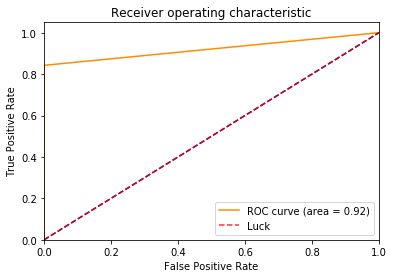

auc_score =  0.519733796296 	feature importances: [ 0.13844341  0.18134341  0.16038443  0.1827862   0.17329139  0.16375116]
auc_score =  0.499768518519 	feature importances: [ 0.12828195  0.17562549  0.16596559  0.16876083  0.19249589  0.16887024]
auc_score =  0.497858796296 	feature importances: [ 0.12989613  0.17846222  0.16588602  0.18491619  0.18012601  0.16071343]
auc_score =  0.500327932099 	feature importances: [ 0.13012019  0.15134906  0.16775065  0.18500446  0.16033373  0.20544191]
auc_score =  0.500212191358 	feature importances: [ 0.12893017  0.16690914  0.1531129   0.19114022  0.16730451  0.19260306]
auc_score =  0.503105709877 	feature importances: [ 0.12986629  0.15853006  0.19007067  0.19454699  0.16569385  0.16129214]
auc_score =  0.498765432099 	feature importances: [ 0.11739762  0.19255633  0.1706276   0.14827603  0.17644984  0.19469258]
auc_score =  0.499749228395 	feature importances: [ 0.13136389  0.17269204  0.16601259  0.17186427  0.16930524  0.18876197]
auc_scor

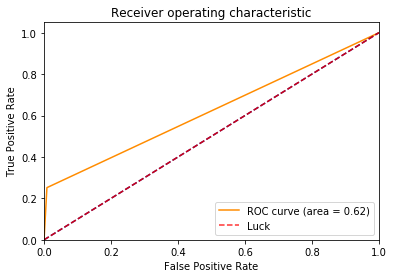

auc_score =  0.919637345679 	feature importances: [ 0.13818715  0.17681261  0.20022966  0.14765647  0.1777826   0.15933151]


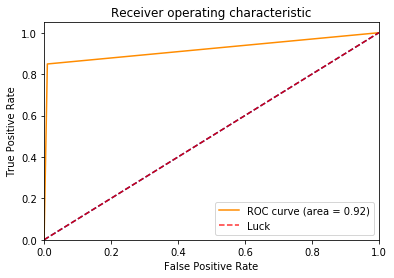

auc_score =  0.697067901235 	feature importances: [ 0.13718394  0.17351115  0.16217039  0.20214064  0.15687742  0.16811646]


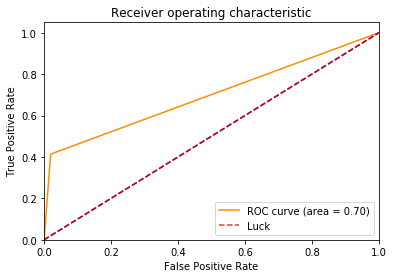

auc_score =  0.611111111111 	feature importances: [ 0.13741774  0.18361347  0.17769015  0.17318317  0.15740866  0.17068682]


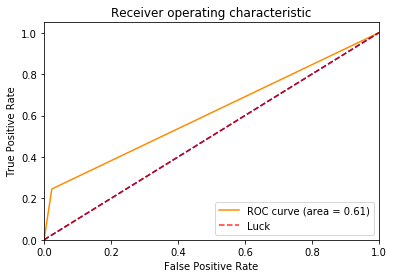

auc_score =  0.504436728395 	feature importances: [ 0.15095802  0.16097214  0.18861949  0.16610434  0.15460785  0.17873816]
auc_score =  0.500462962963 	feature importances: [ 0.11945207  0.15258822  0.20032628  0.1645459   0.18413794  0.17894959]
auc_score =  0.499903549383 	feature importances: [ 0.13930122  0.16572759  0.17980388  0.15993087  0.18245277  0.17278367]
auc_score =  0.500327932099 	feature importances: [ 0.1241372   0.15812356  0.19914479  0.16014868  0.19329564  0.16515013]
auc_score =  0.499209104938 	feature importances: [ 0.13455205  0.17087846  0.17485036  0.17504719  0.18606704  0.1586049 ]
auc_score =  0.497685185185 	feature importances: [ 0.12431839  0.1963395   0.17714278  0.14749286  0.16946787  0.1852386 ]
auc_score =  0.501350308642 	feature importances: [ 0.12221079  0.16923697  0.17655045  0.16867224  0.18526693  0.17806262]
auc_score =  0.499884259259 	feature importances: [ 0.13422582  0.16620566  0.17457052  0.19262322  0.17472771  0.15764707]
auc_scor

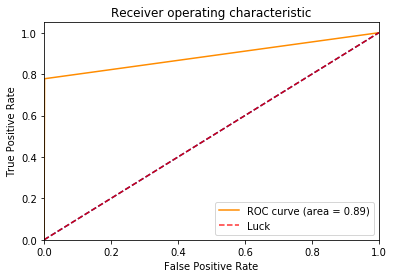

auc_score =  0.781732253086 	feature importances: [ 0.10959817  0.18626412  0.17041133  0.17961255  0.20226237  0.15185145]


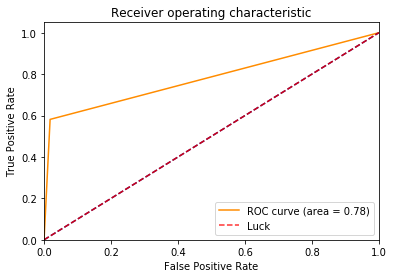

auc_score =  0.498206018519 	feature importances: [ 0.12261021  0.18359049  0.17500427  0.17860495  0.17834502  0.16184506]
auc_score =  0.503356481481 	feature importances: [ 0.12824556  0.17467555  0.17466813  0.17803473  0.14895     0.19542603]
auc_score =  0.500173611111 	feature importances: [ 0.14426404  0.15476972  0.19130008  0.1686377   0.16081348  0.18021497]
auc_score =  0.502353395062 	feature importances: [ 0.1293187   0.17279611  0.18584744  0.19686605  0.16390869  0.15126302]
auc_score =  0.50050154321 	feature importances: [ 0.12143785  0.16250857  0.20026931  0.17294598  0.17444745  0.16839084]
auc_score =  0.500096450617 	feature importances: [ 0.12674518  0.17218568  0.16901194  0.16076292  0.17882799  0.1924663 ]
auc_score =  0.5015625 	feature importances: [ 0.11950981  0.18300017  0.18053026  0.16811356  0.17665703  0.17218917]
auc_score =  0.499672067901 	feature importances: [ 0.11142189  0.19319066  0.18498368  0.16837199  0.19041158  0.1516202 ]
auc_score =  0

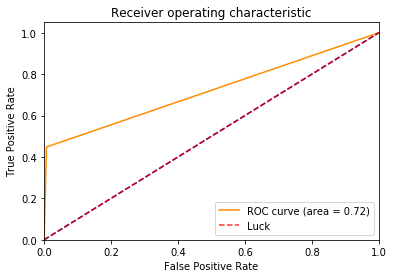

auc_score =  0.825482253086 	feature importances: [ 0.13851133  0.18327492  0.15716464  0.17296906  0.18519798  0.16288207]


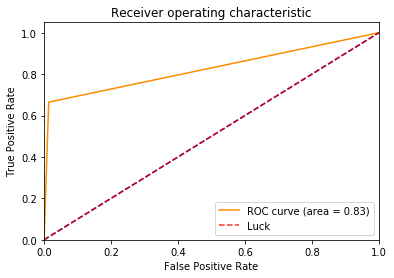

auc_score =  0.538194444444 	feature importances: [ 0.0965074   0.19535381  0.14733858  0.18724663  0.19849333  0.17506026]
auc_score =  0.498263888889 	feature importances: [ 0.10451233  0.16956484  0.17199129  0.17522638  0.20599632  0.17270884]
auc_score =  0.502507716049 	feature importances: [ 0.11314718  0.16847366  0.18790189  0.17398883  0.16972426  0.18676419]
auc_score =  0.503395061728 	feature importances: [ 0.12794218  0.18100562  0.17208259  0.17807419  0.16746995  0.17342548]
auc_score =  0.498418209877 	feature importances: [ 0.12570761  0.18574143  0.16327214  0.19796303  0.16850133  0.15881446]
auc_score =  0.498263888889 	feature importances: [ 0.12595127  0.18160703  0.18283329  0.19073124  0.16196754  0.15690963]
auc_score =  0.501311728395 	feature importances: [ 0.12662497  0.16775804  0.16964118  0.19941182  0.14936182  0.18720217]
auc_score =  0.500327932099 	feature importances: [ 0.13627407  0.16268672  0.17803982  0.18505588  0.16060889  0.17733461]
auc_scor

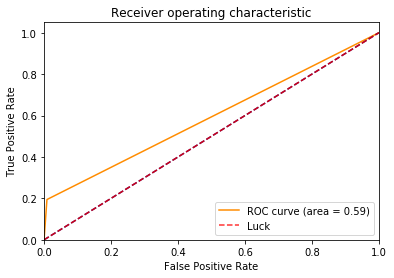

auc_score =  0.958892746914 	feature importances: [ 0.12596321  0.21238487  0.17582393  0.14742902  0.16666203  0.17173695]


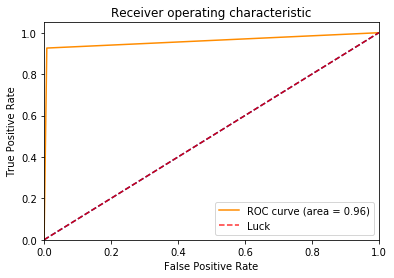

auc_score =  0.705439814815 	feature importances: [ 0.11787579  0.18633984  0.17805576  0.19552627  0.14681594  0.17538639]


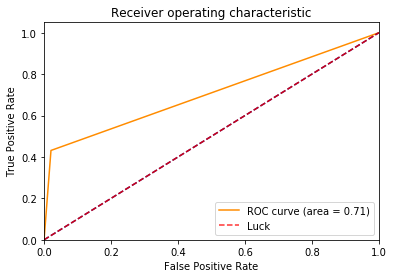

auc_score =  0.625848765432 	feature importances: [ 0.12404166  0.18919252  0.17152762  0.18099271  0.16805521  0.16619028]


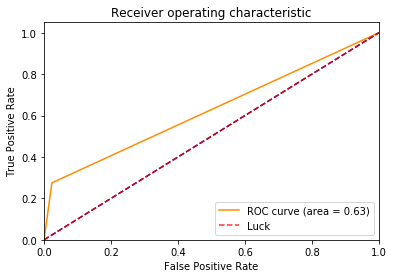

auc_score =  0.501755401235 	feature importances: [ 0.12252023  0.18509765  0.17271463  0.18047338  0.18445654  0.15473756]
auc_score =  0.500906635802 	feature importances: [ 0.12822453  0.16742464  0.17970686  0.1647099   0.17052159  0.18941248]
auc_score =  0.503722993827 	feature importances: [ 0.12980075  0.16760568  0.1933693   0.17359658  0.16904918  0.1665785 ]
auc_score =  0.502989969136 	feature importances: [ 0.15141731  0.18404855  0.15169384  0.17030977  0.16559322  0.17693729]
auc_score =  0.500154320988 	feature importances: [ 0.14344666  0.15746508  0.16336532  0.20312296  0.16399392  0.16860606]
auc_score =  0.501736111111 	feature importances: [ 0.10636663  0.22043783  0.18444697  0.18708109  0.15463463  0.14703286]
auc_score =  0.501041666667 	feature importances: [ 0.09714713  0.21123652  0.17437944  0.18303131  0.15693286  0.17727274]
auc_score =  0.500887345679 	feature importances: [ 0.13417549  0.16980013  0.17133289  0.16449796  0.16603571  0.19415782]
auc_scor

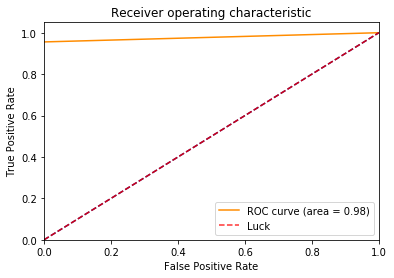

auc_score =  0.738117283951 	feature importances: [ 0.1394437   0.16328608  0.15807017  0.16701214  0.18657773  0.18561019]


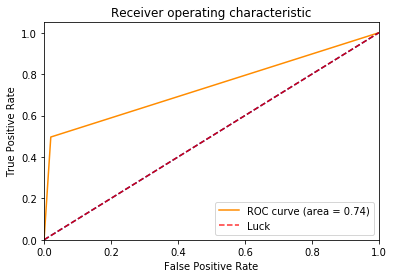

auc_score =  0.635339506173 	feature importances: [ 0.12128302  0.16931382  0.17836322  0.15892009  0.17866388  0.19345596]


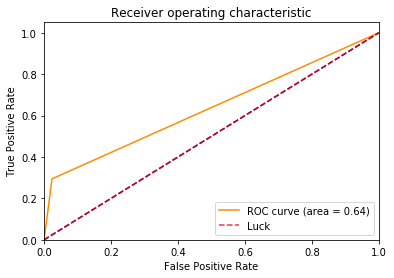

auc_score =  0.502295524691 	feature importances: [ 0.13763703  0.20992906  0.17223897  0.16152839  0.17129716  0.1473694 ]
auc_score =  0.501388888889 	feature importances: [ 0.12524592  0.16709127  0.16541967  0.17185933  0.1506639   0.21971992]
auc_score =  0.502353395062 	feature importances: [ 0.13496785  0.15347575  0.19871735  0.15072051  0.17185736  0.19026118]
auc_score =  0.500925925926 	feature importances: [ 0.12740614  0.17879975  0.14899235  0.1791564   0.17530947  0.19033589]
auc_score =  0.499980709877 	feature importances: [ 0.13731086  0.14581264  0.172916    0.18278209  0.17236682  0.18881159]
auc_score =  0.503260030864 	feature importances: [ 0.11445899  0.17989712  0.18614911  0.15497485  0.18707036  0.17744958]
auc_score =  0.499363425926 	feature importances: [ 0.1316576   0.16038702  0.16190549  0.19176041  0.15669838  0.1975911 ]
auc_score =  0.49949845679 	feature importances: [ 0.14487867  0.16963143  0.17468753  0.19125786  0.1612691   0.15827542]
auc_score

In [ ]:
start_time = time.time()

#find min and max timestamps

start = df.index.min()
end = df.index.max()

#round start 
start.seconds=0
start.minutes=0

ref = window * Hour()
sub = 1 * Hour()

# loop over them
ti=start+ref+sub
count=0
while ti < end + 1 * Minute():
    ref_start = ti-ref-sub
    ref_end = ti-sub
    ref_df = df[(df.index >= ref_start) & (df.index < ref_end)]
    #print("In while loop: ref_df: ", ref_df)
    sub_df = df[(df.index >= ref_end) & (df.index < ti)]
    #print("In while loop: sub_df: ", sub_df)
    auc_score = check_for_anomaly(ref_df, sub_df)
    df.loc[(df.index>=ref_end) & (df.index<=ti),['auc_score']] = auc_score
    #print(ti,"\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0], '\tauc:', auc_score)
    ti = ti + sub
    count=count+1
    #if count>2: break
    


In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
print(start)
print(end)

In [ ]:
#df.plot(figsize=(20,7))

df.plot(figsize=(20,7))
plt.xlabel('Time', fontsize=18)
plt.ylabel('Variance in Data', fontsize=16)
plt.legend(df)

In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
df.loc[:,'Detected'] = 0
df.loc[df.auc_score>0.55,'Detected']=1
df.head()
ax.plot(df.Flag, 'r')
ax.plot(df.auc_score,'g')
ax.fill( df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.xlabel('Time', fontsize=18)
plt.ylabel('AUC score', fontsize=16)
plt.show()